# Percentiles

Assessment of model percentiles 99th, 99.5th, and 99.9th (1st, 0.5th and 0.1st for Tasmin) over the 2000-2019 period.

(Bias corrected data for the period 2000-2019 was produced by training on data from the 1980-1999 period.)

In [26]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [27]:
def calc_perc(da, var):
    """Calculate the averaged 5-year maximum (minimum for Tasmin)"""
    
    if var == 'pr' or var == 'tasmax':
        mode = 'upper percentiles'
        percentiles_99 = da.chunk({'time': -1}).quantile(0.99, dim='time')
        percentiles_995 = da.chunk({'time': -1}).quantile(0.995, dim='time')
        percentiles_999 = da.chunk({'time': -1}).quantile(0.999, dim='time')
        return percentiles_99, percentiles_995, percentiles_999, mode
    else:
        mode = 'lower percentiles'
        percentiles_01 = da.chunk({'time': -1}).quantile(0.01, dim='time')
        percentiles_005 = da.chunk({'time': -1}).quantile(0.005, dim='time')
        percentiles_001 = da.chunk({'time': -1}).quantile(0.001, dim='time')       
        return percentiles_01, percentiles_005, percentiles_001, mode
     

In [28]:
def get_data(var, rcm):
    """Get data needed for the evaluation"""

    assert rcm in ['BOM-BARPA-R', 'UQ-DES-CCAM-2105']
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )   
    da_gcm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        'GCM',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    da_rcm_raw = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    da_rcm_ecdfm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'ecdfm',
        'task-historical',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    # TODO: Add additional bias correction methods as data becomes available 

    return da_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm

In [29]:
def plot_mean_bias(ax, da_obs, da_model, var, cmap, levels, model_name, mode, percentile):
    """Plot the mean bias for a particular model"""
    
    perc1_obs, perc2_obs, perc3_obs, _ = calc_perc(da_obs, var)  
    perc1_model, perc2_model, perc3_model, _ = calc_perc(da_model, var) 

    if var == 'pr' or var == 'tasmax' and percentile == '99th':
        bias = perc1_model - perc1_obs #99th p.
    elif var == 'pr' or var == 'tasmax' and percentile == '99.5th':
        bias = perc2_model - perc2_obs #99.5th p.
    elif var == 'pr' or var == 'tasmax' and percentile == '99.9th':
        bias = perc3_model - perc3_obs #99.9th p.
    elif var == 'tasmin' and percentile == '1st':
        bias = perc1_model - perc1_obs #1st p.
    elif var == 'tasmin' and percentile == '0.5th':
        bias = perc2_model - perc2_obs #0.5th p.
    elif var == 'tasmin' and percentile == '0.1st':
        bias = perc3_model - perc3_obs #0.1st p.
    else:
        print('Invalid percentile value or invalid variable')
        return
    
    units = 'mm/day' if var == 'pr' else da_model.attrs['units']
    
    im = bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both', 
        add_colorbar=False
    ) #cbar_kwargs={'label': units},
    ax.set_title(model_name)
    ax.coastlines()
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.04)
    cbar.ax.tick_params(labelsize=14)  
    cbar.set_label(units, fontsize=14) 


In [30]:
def plot_comparison(var, rcm, cmap, levels):
    """Plot the complete comparison"""

    da_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm = get_data(var, rcm)

    if var == 'pr' or var == 'tasmax':
        percentiles = ['99th', '99.5th', '99.9th']  
    elif var == 'tasmin':
        percentiles = ['1st', '0.5th', '0.1st']
    else:
        print('Invalid variable')
        
    rows, cols = len(percentiles), 3  
    
    fig, axs = plt.subplots(rows, cols, figsize=[24, 6*rows], subplot_kw={'projection': ccrs.PlateCarree()})
    
    for row, percentile in enumerate(percentiles):
        _, _, _, mode = calc_perc(da_obs, var)  # get mode "upper percentiles" or "lower percentiles"

        ax1 = axs[row, 0]
        ax2 = axs[row, 1]
        ax3 = axs[row, 2]

        # Plot GCM bias
        plot_mean_bias(ax1, da_obs, da_gcm, var, cmap, levels, 'CSIRO-ACCESS-ESM1-5', mode, percentile)
        ax1.set_title(f'CSIRO-ACCESS-ESM1-5 ({percentile})', fontsize=16)

        # Plot RCM raw bias
        plot_mean_bias(ax2, da_obs, da_rcm_raw, var, cmap, levels, f'{rcm} (raw)', mode, percentile)
        ax2.set_title(f'{rcm} (raw) ({percentile})', fontsize=16)

        # Plot RCM bias corrected bias
        plot_mean_bias(ax3, da_obs, da_rcm_ecdfm, var, cmap, levels, f'{rcm} (ecdfm)', mode, percentile)
        ax3.set_title(f'{rcm} (ecdfm) ({percentile})', fontsize=16)
    
    long_name = da_rcm_raw.attrs['long_name']
    plt.suptitle(mode.capitalize() + f' bias (model minus obs) for different percentiles in the 2000-2019 {long_name}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


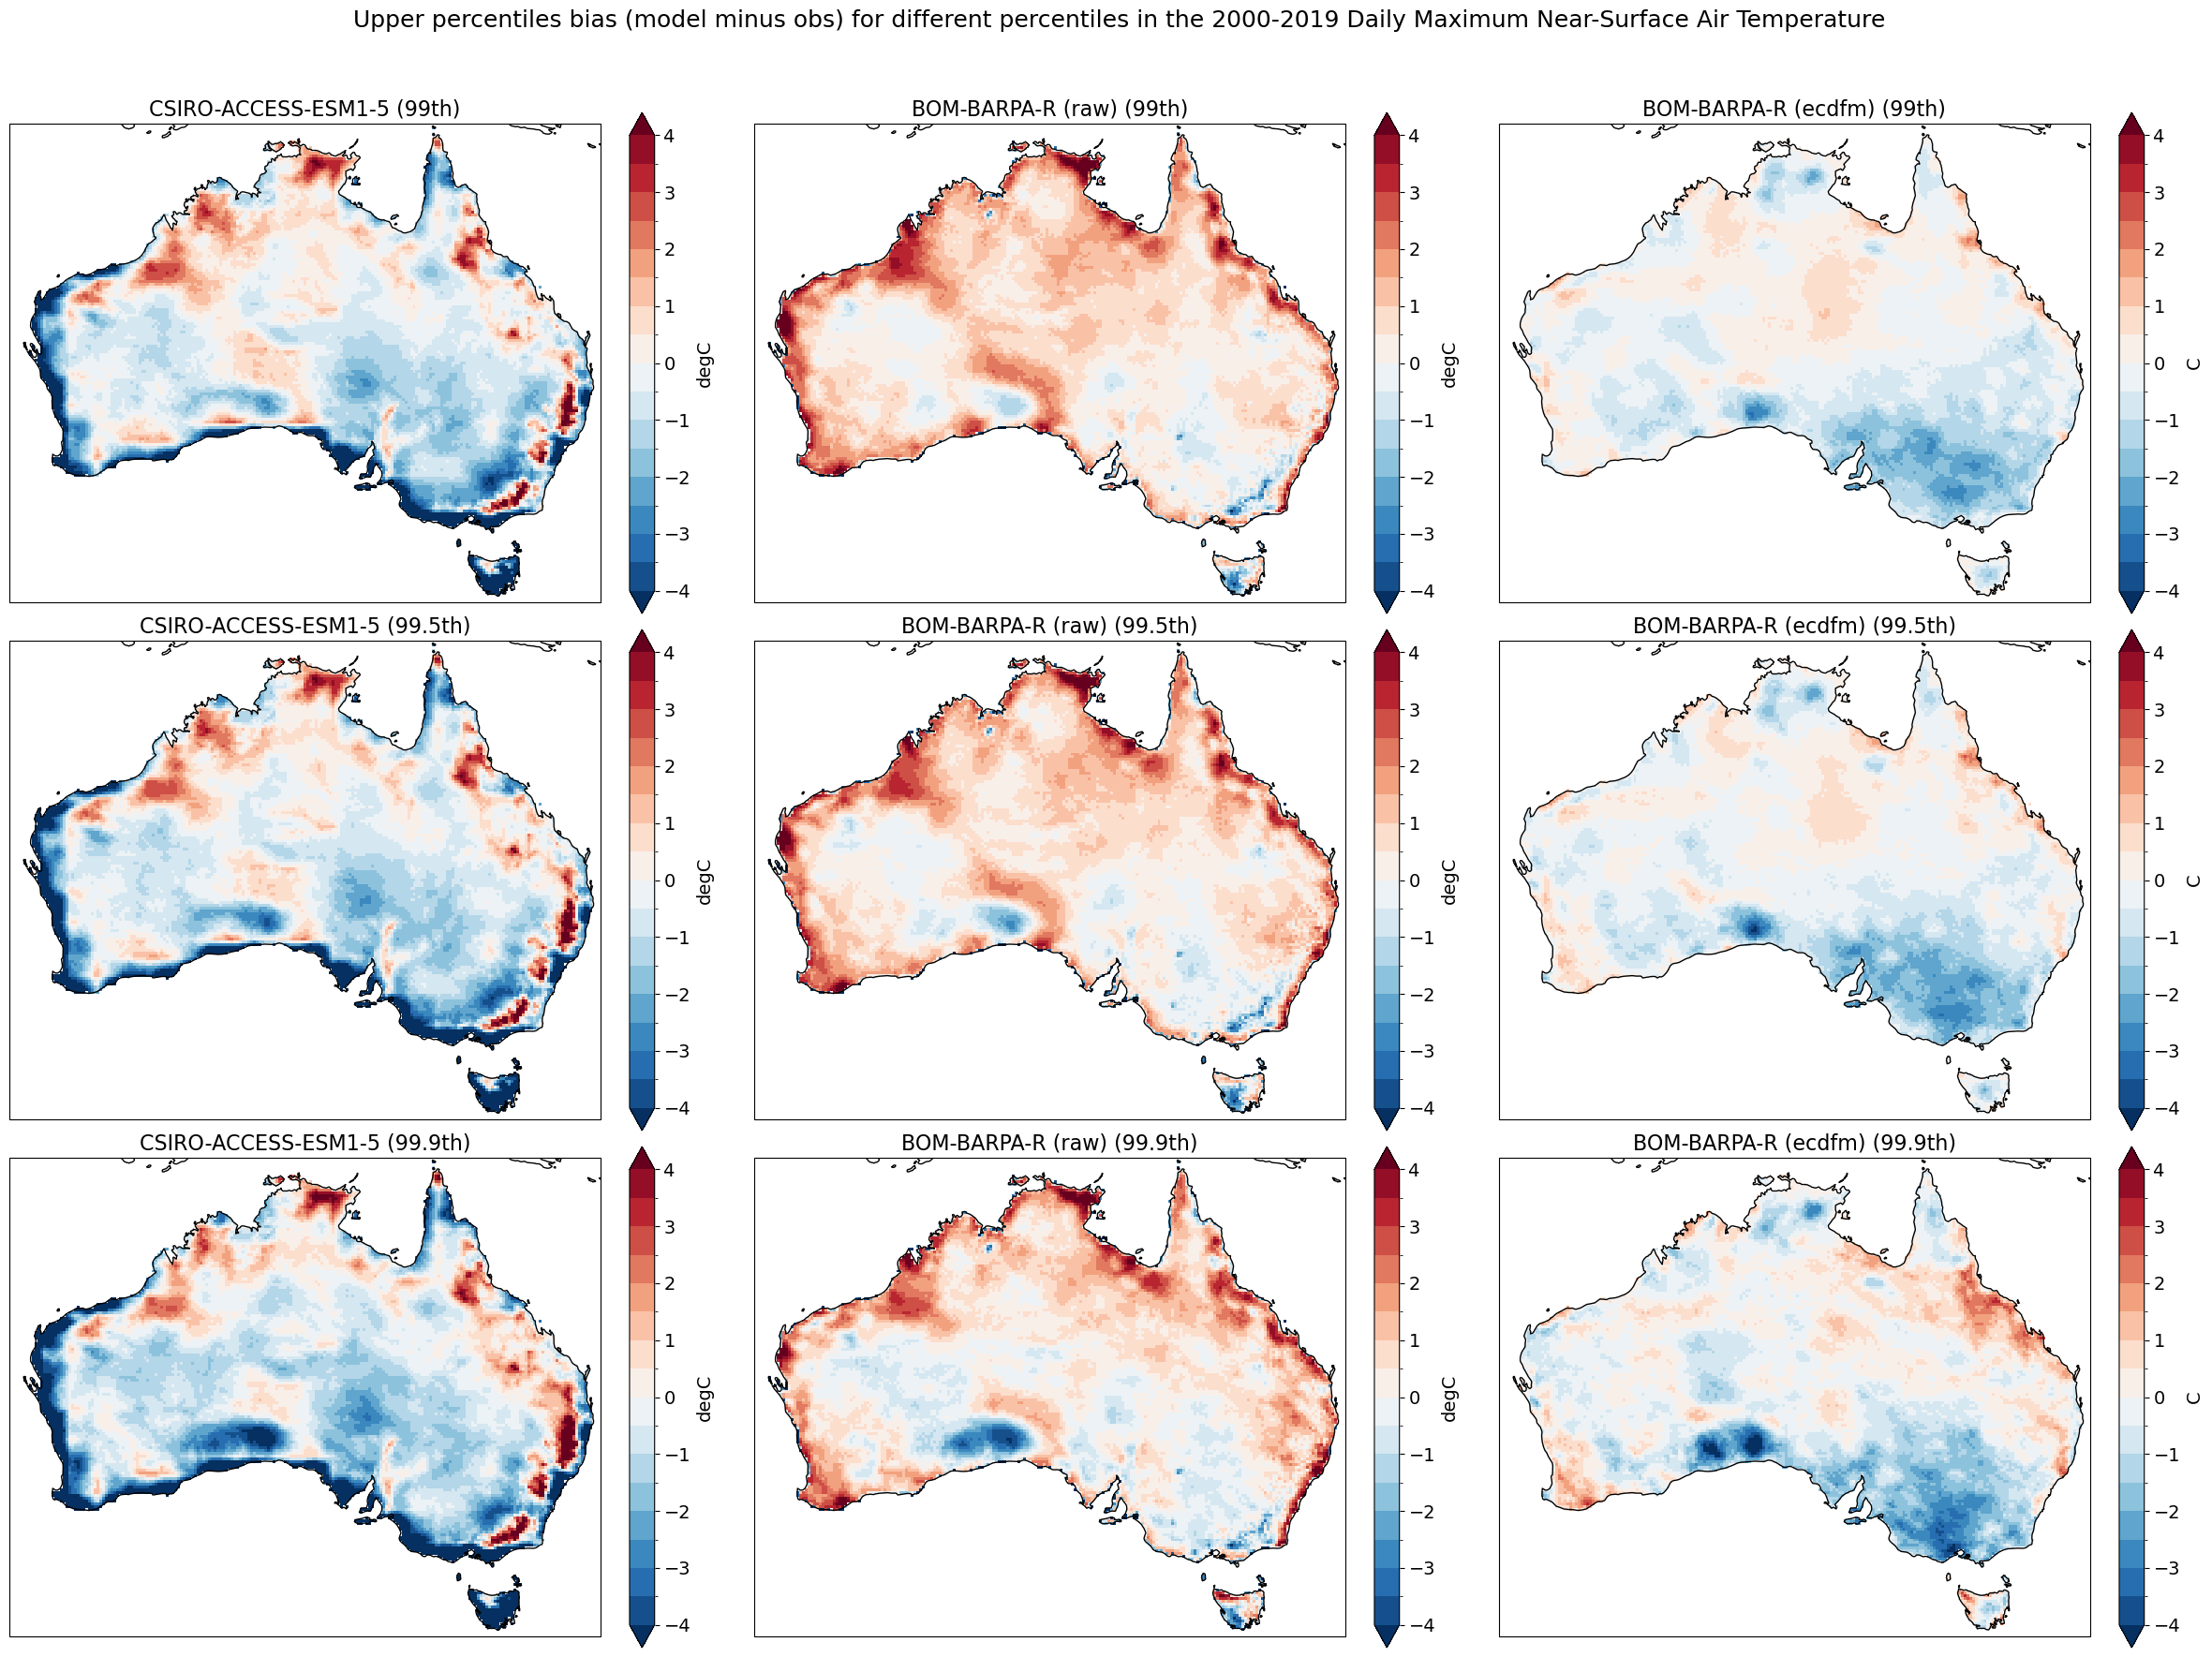

In [31]:
plot_comparison('tasmax', 'BOM-BARPA-R', 'RdBu_r', np.arange(-4, 4.01, 0.5))

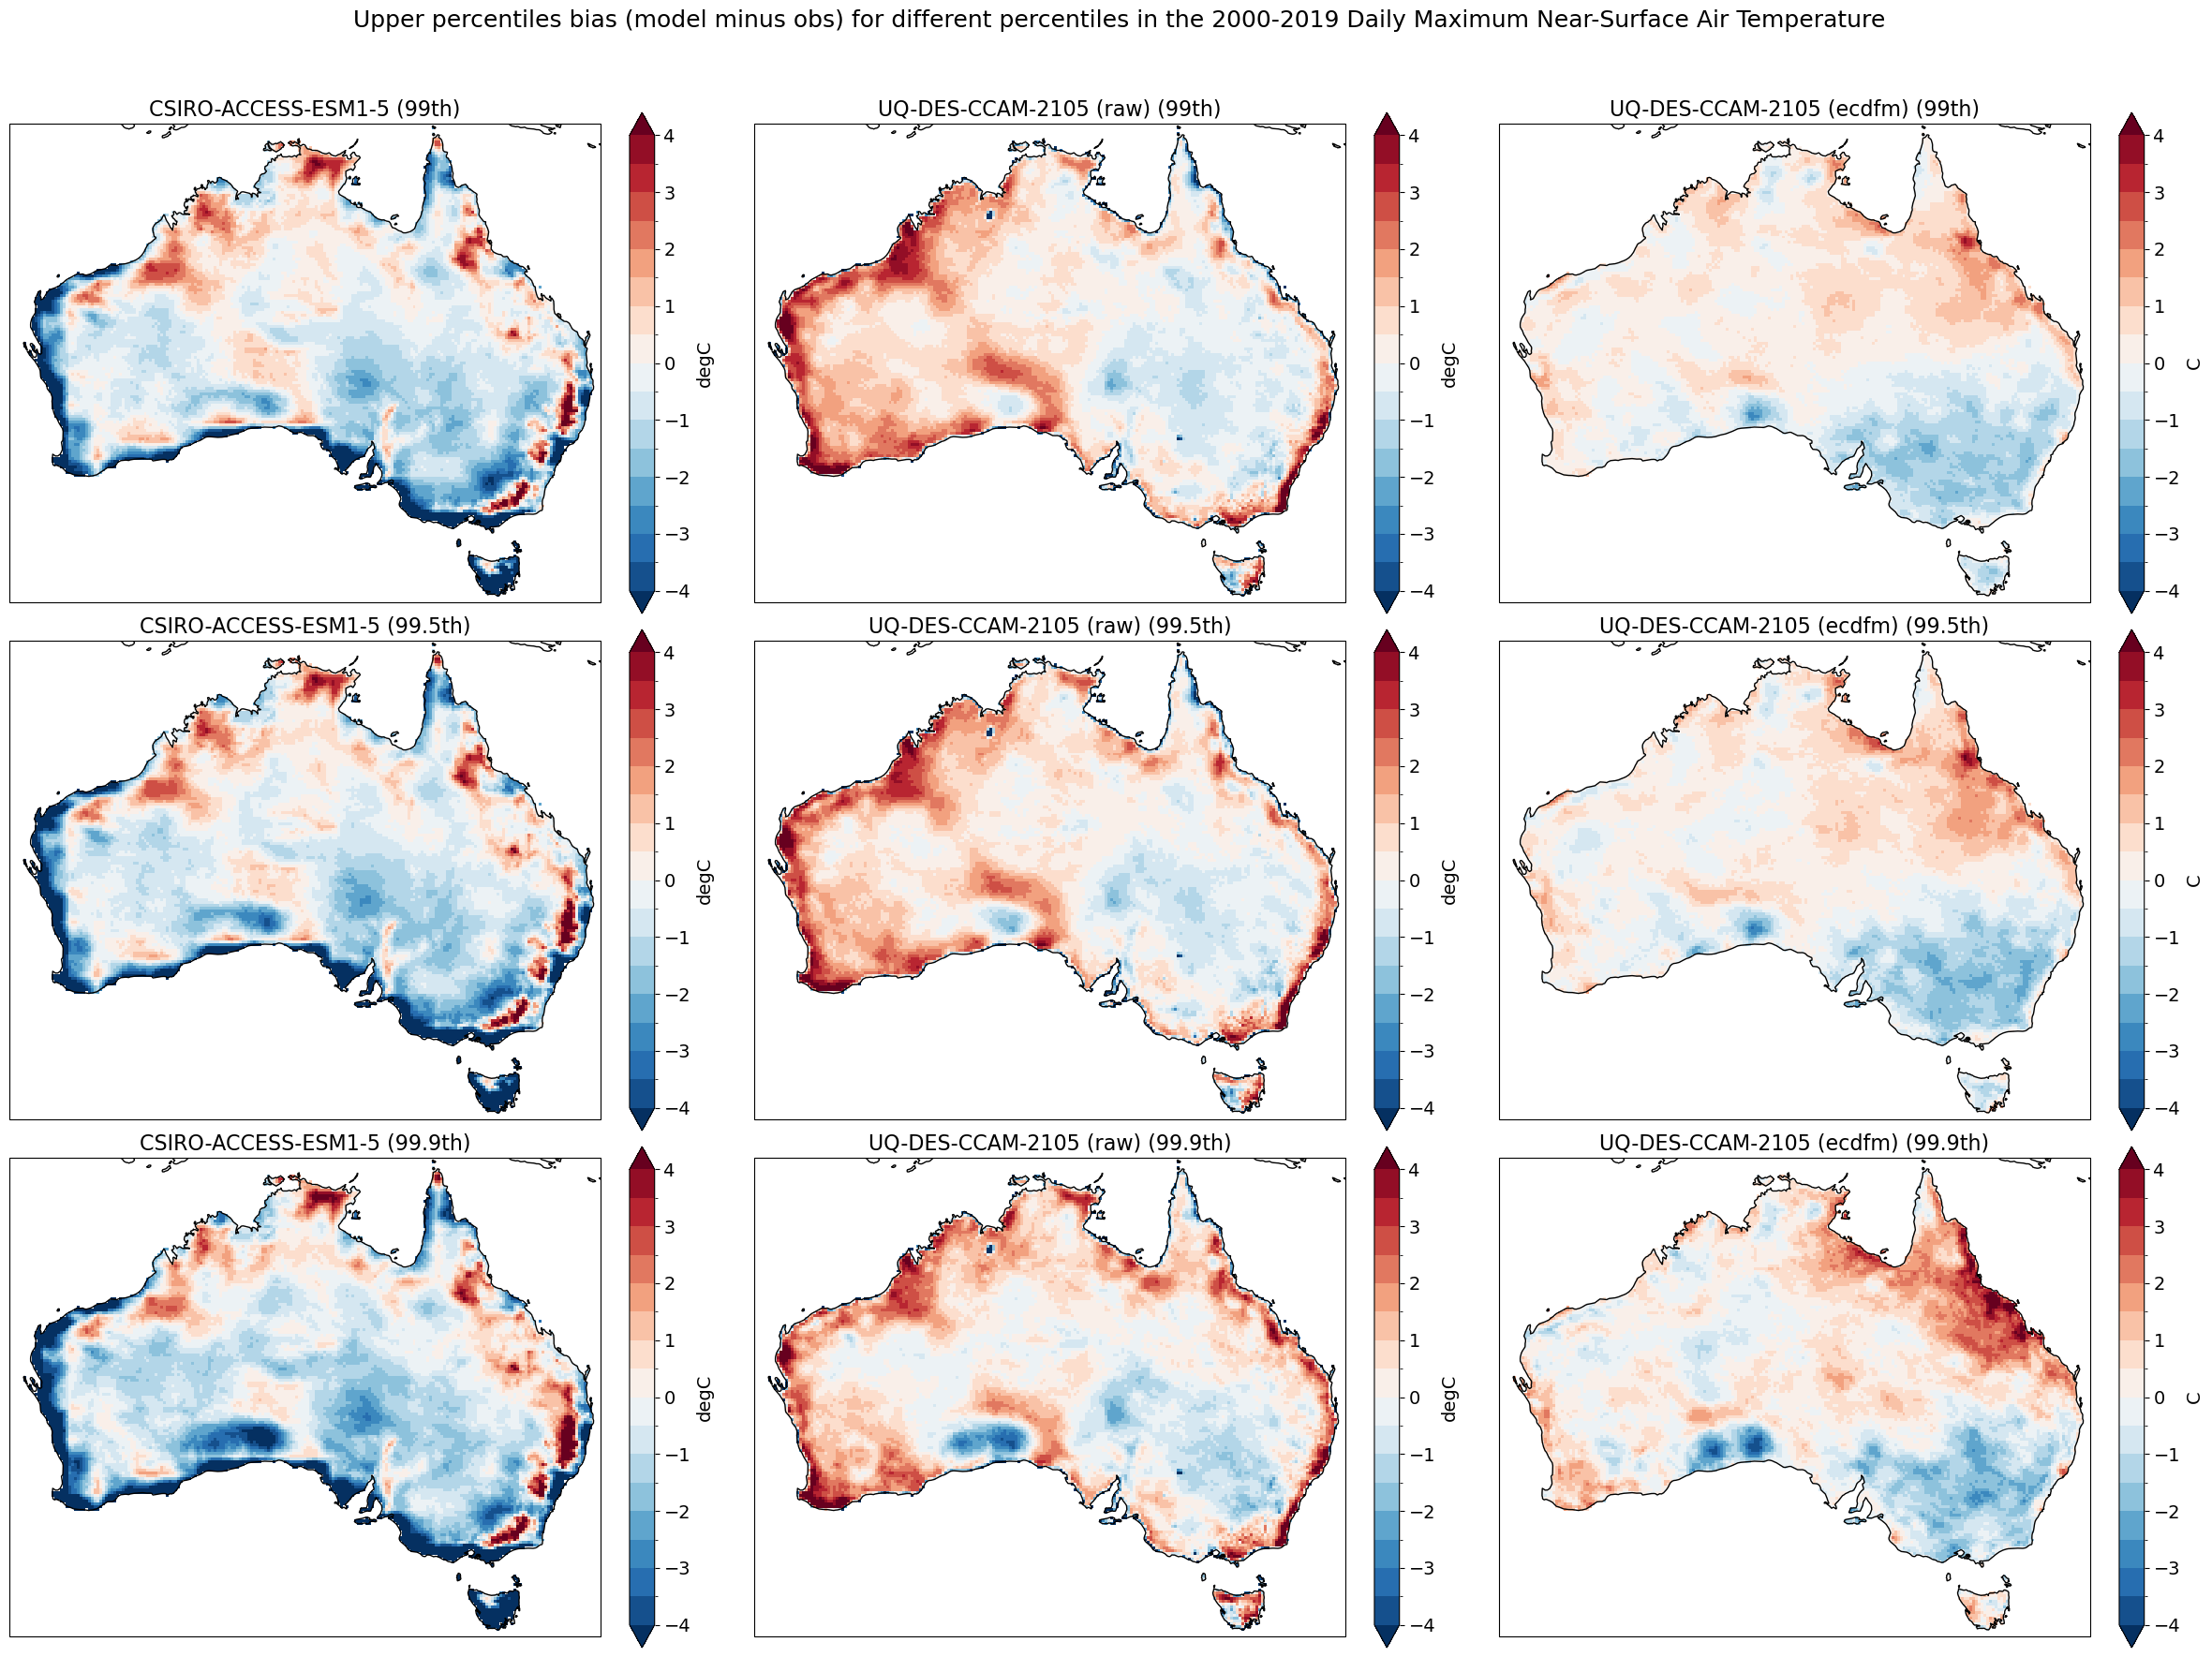

In [32]:
plot_comparison('tasmax', 'UQ-DES-CCAM-2105', 'RdBu_r', np.arange(-4, 4.01, 0.5))

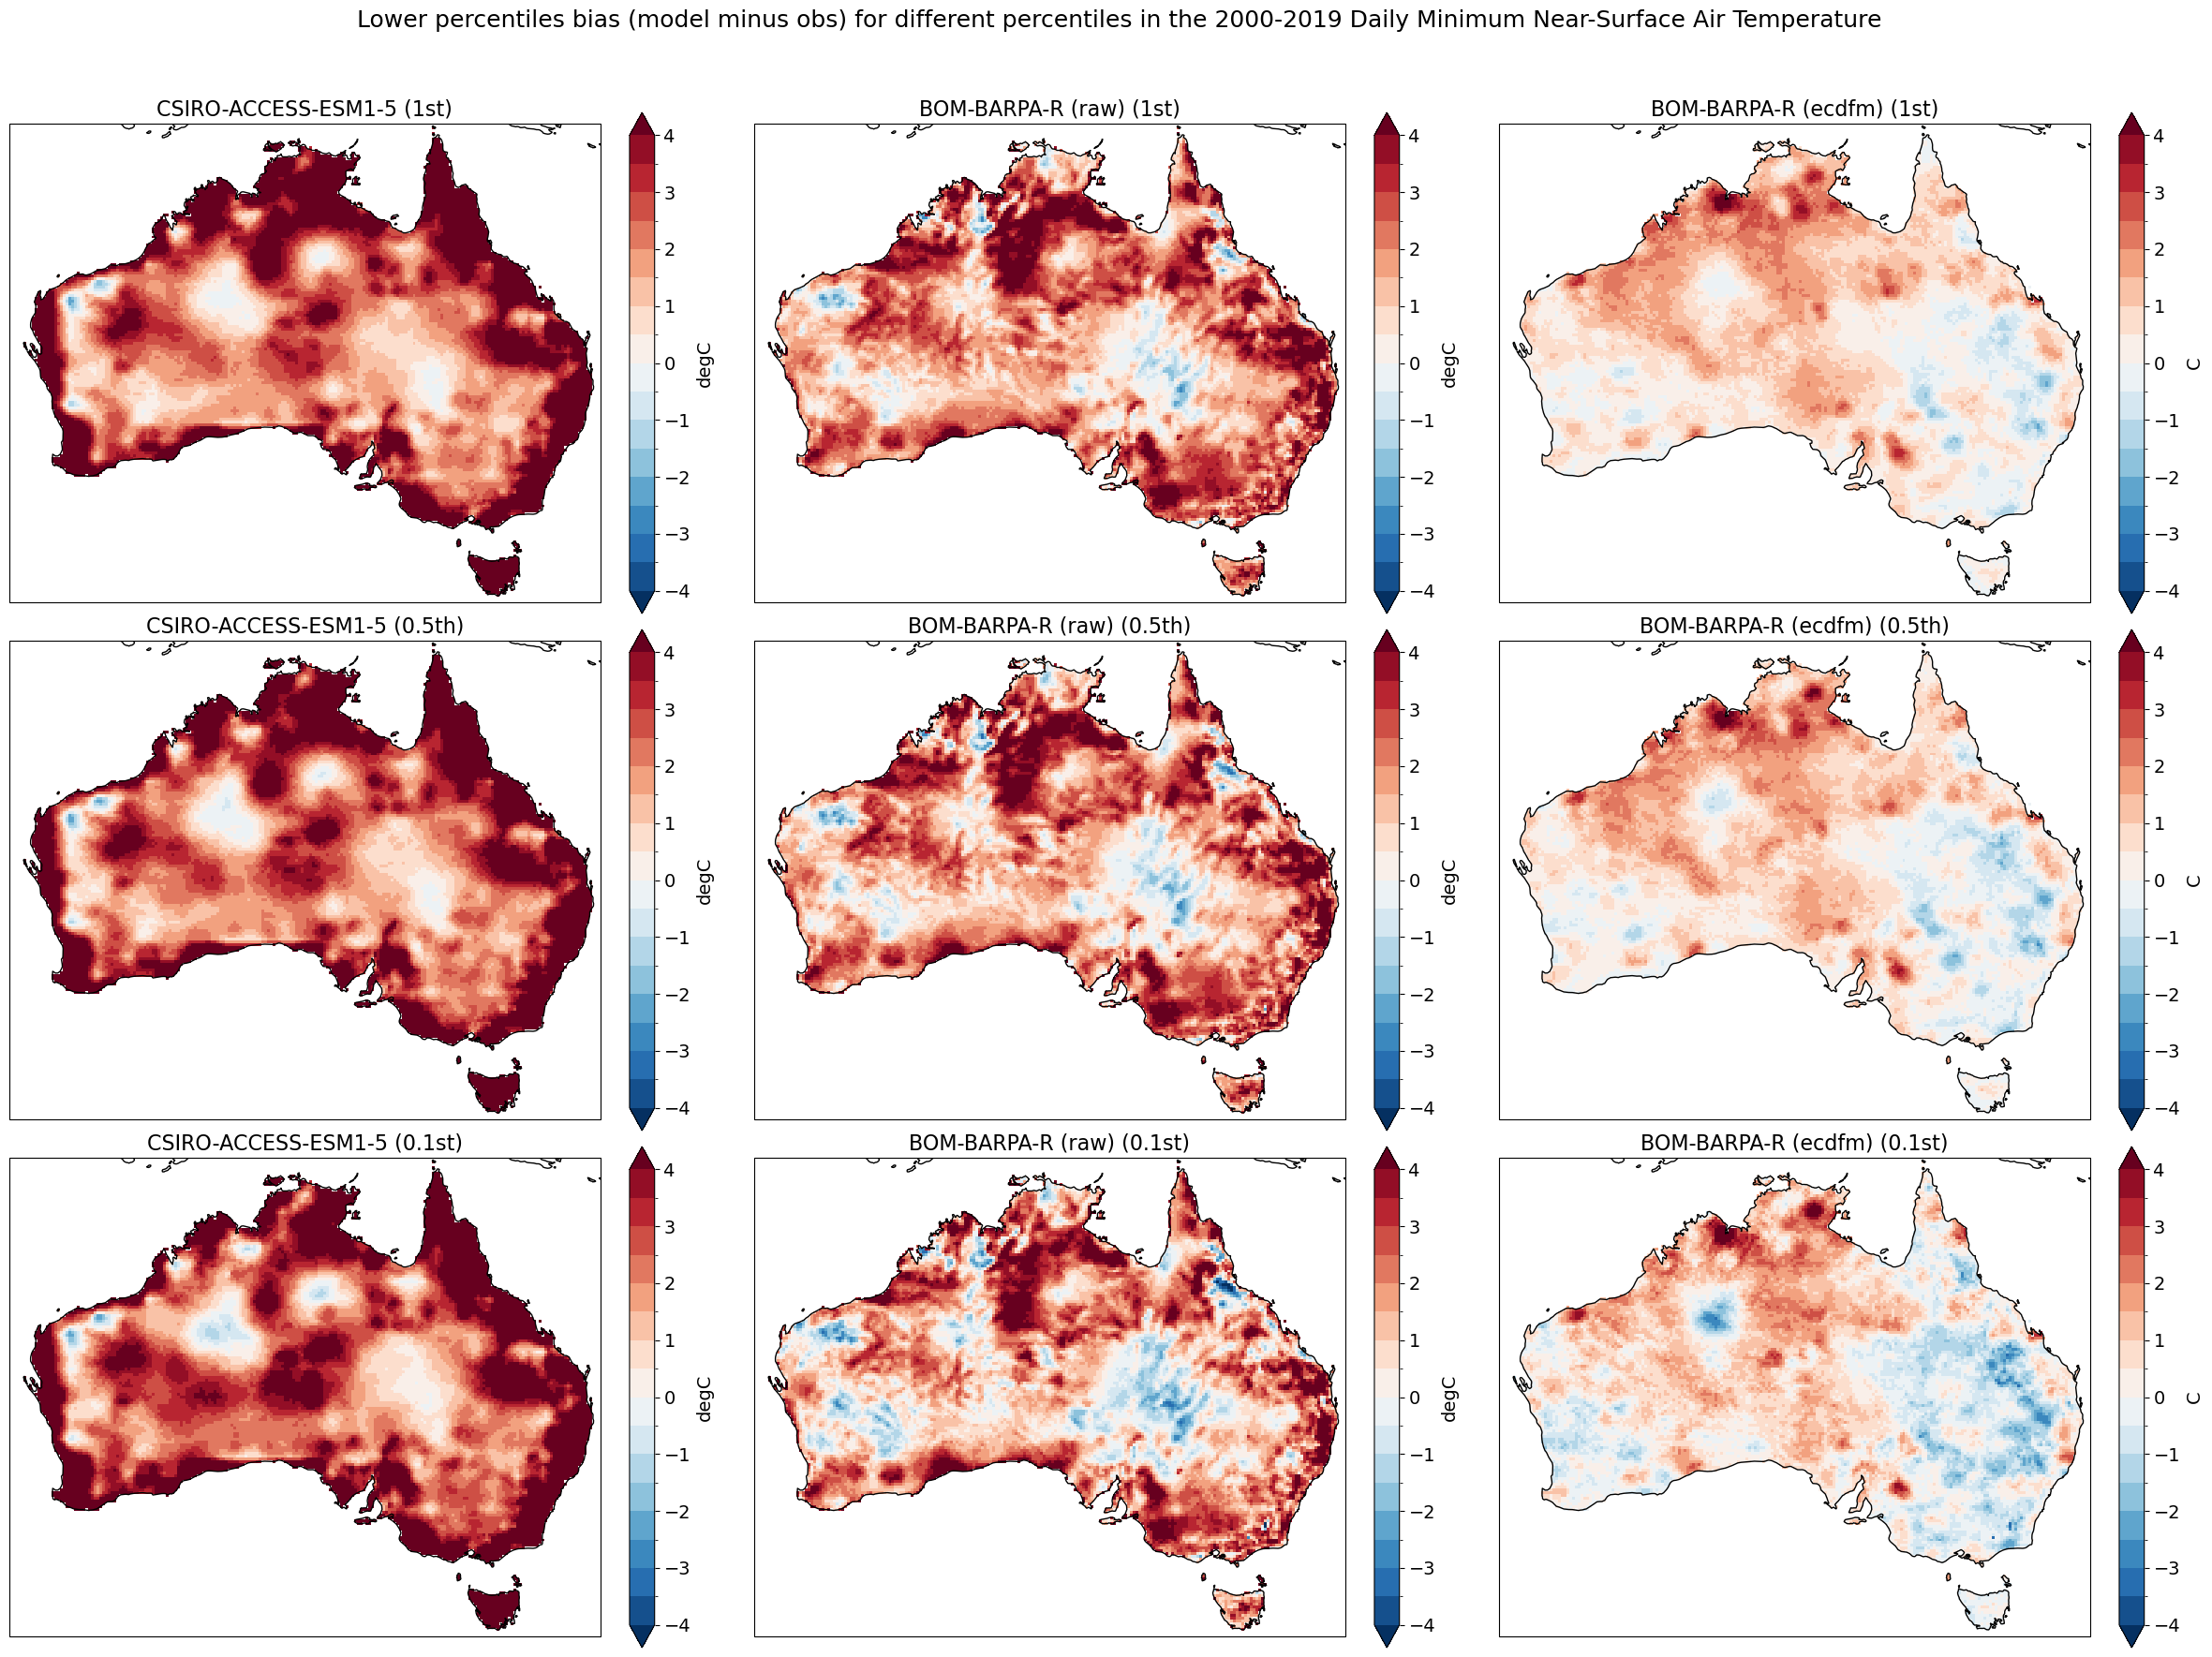

In [33]:
plot_comparison('tasmin', 'BOM-BARPA-R', 'RdBu_r', np.arange(-4, 4.01, 0.5))

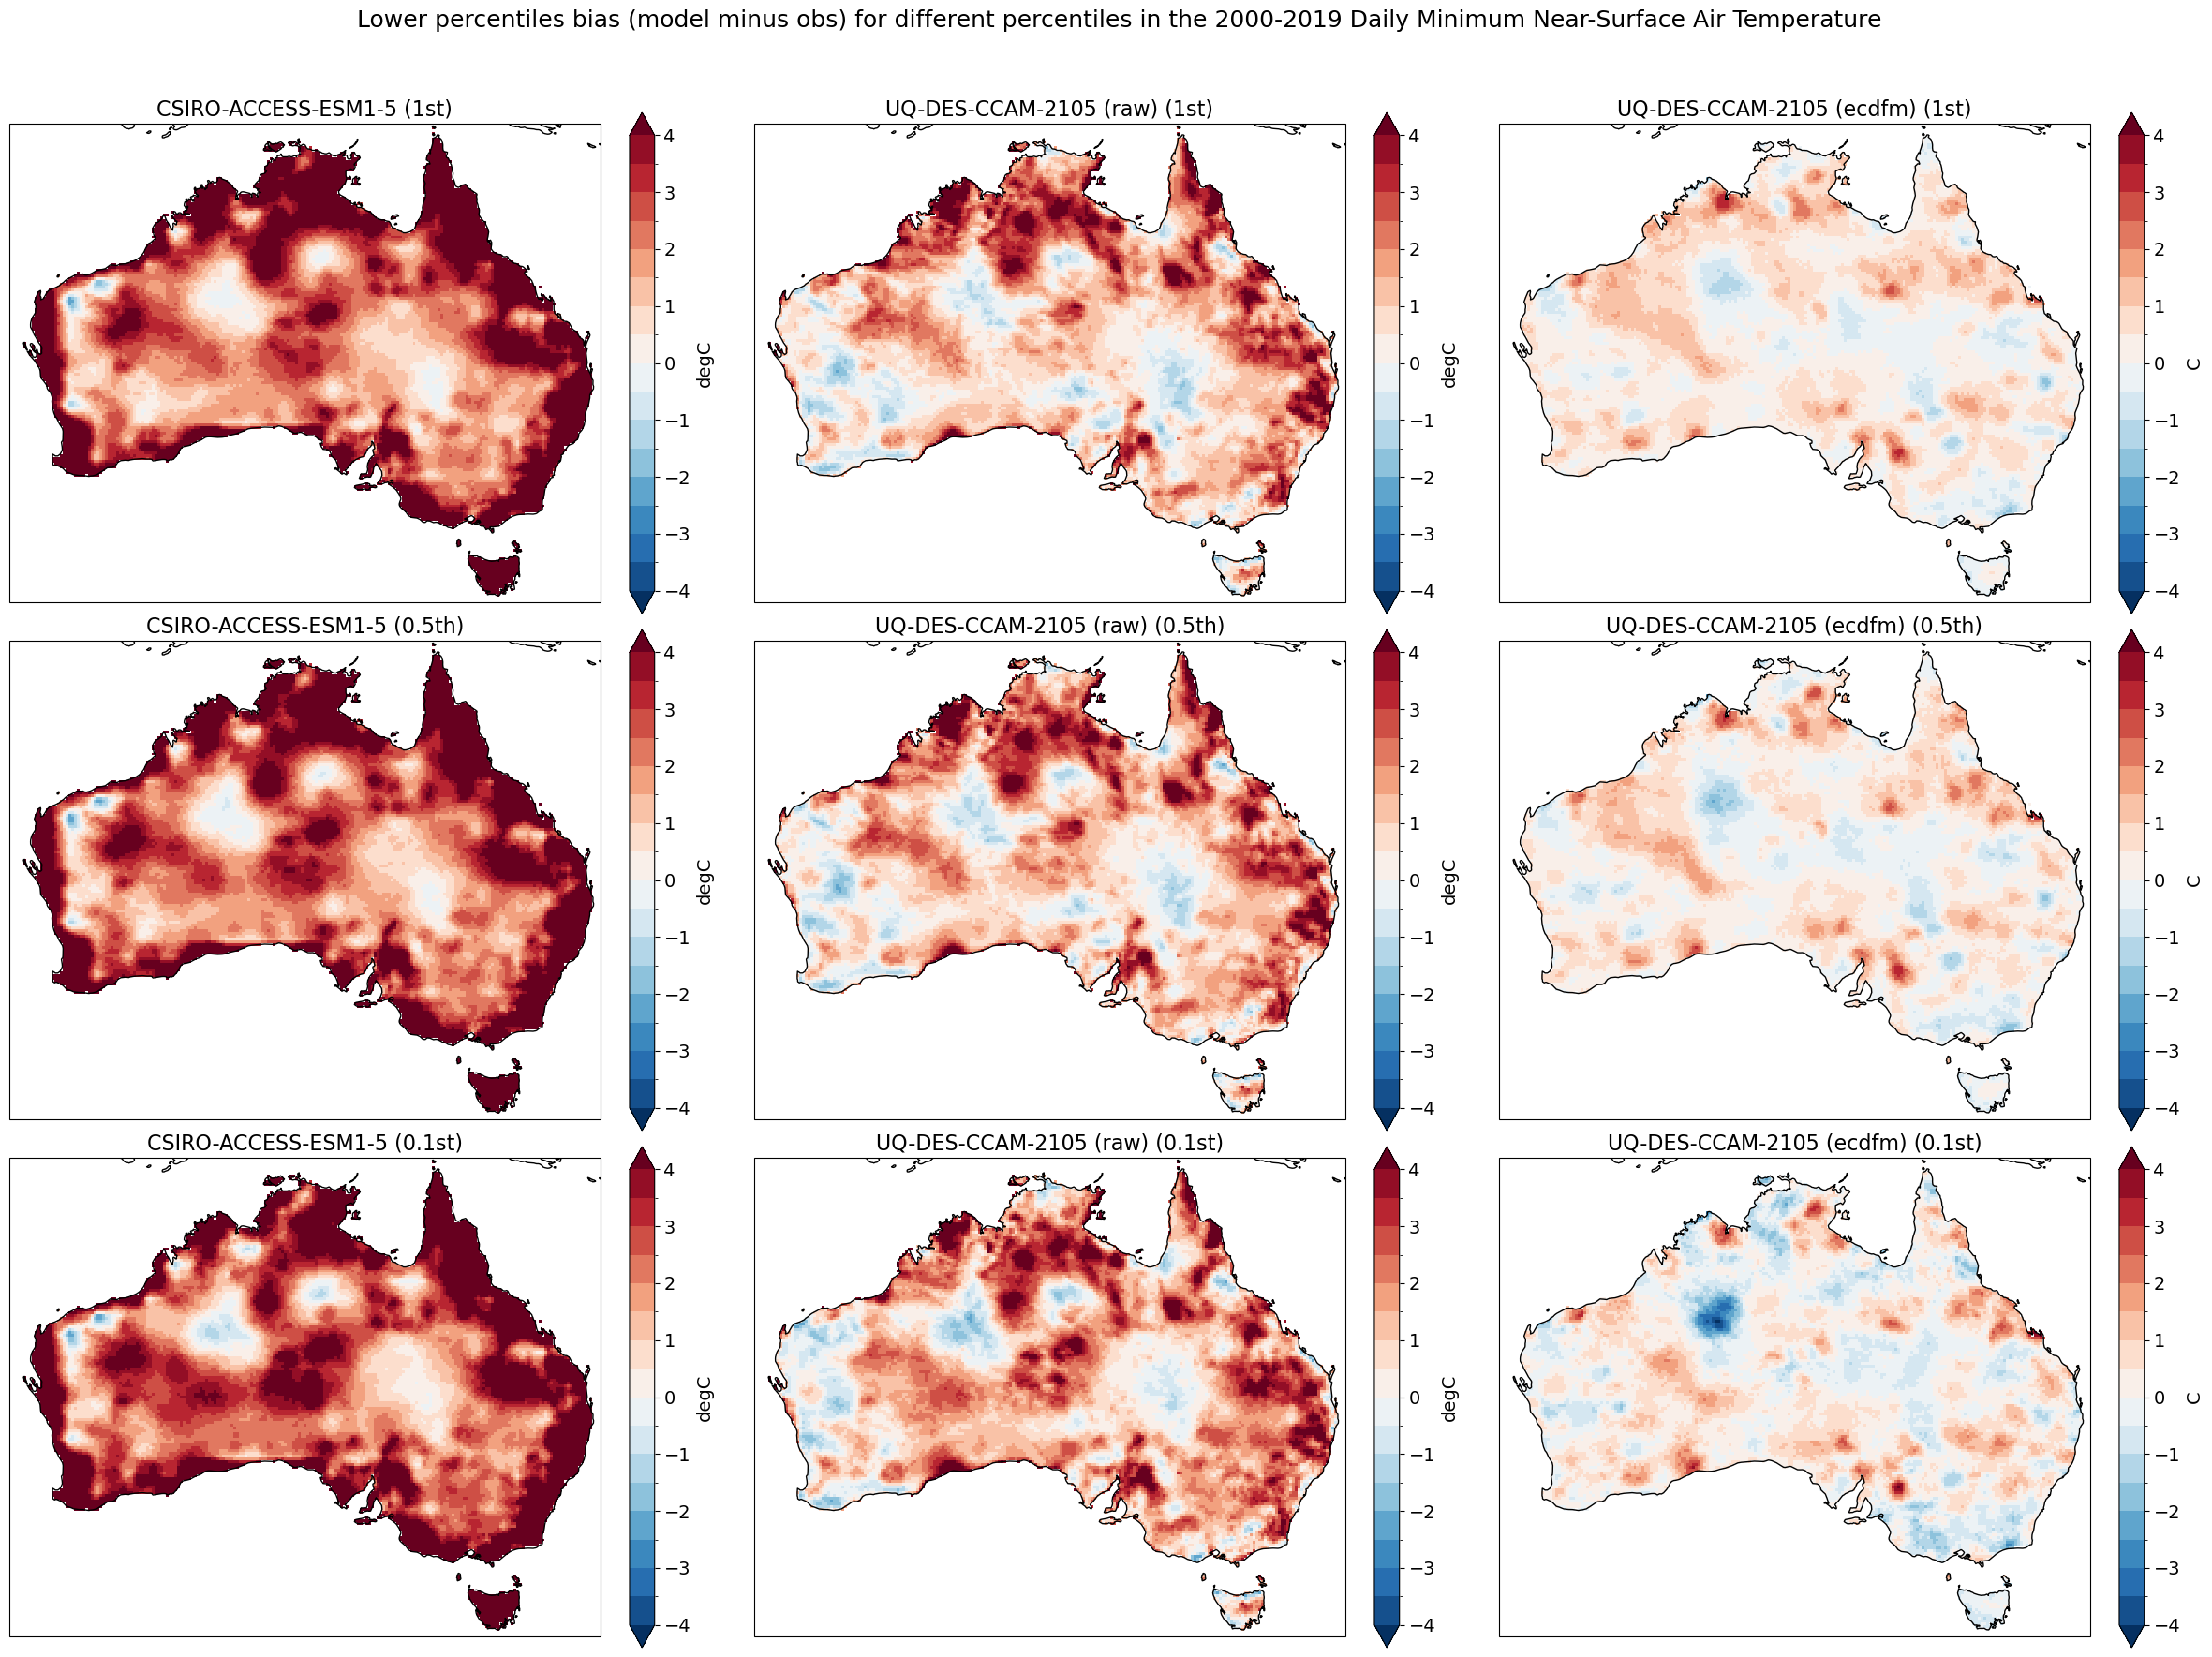

In [34]:
plot_comparison('tasmin', 'UQ-DES-CCAM-2105', 'RdBu_r', np.arange(-4, 4.01, 0.5))

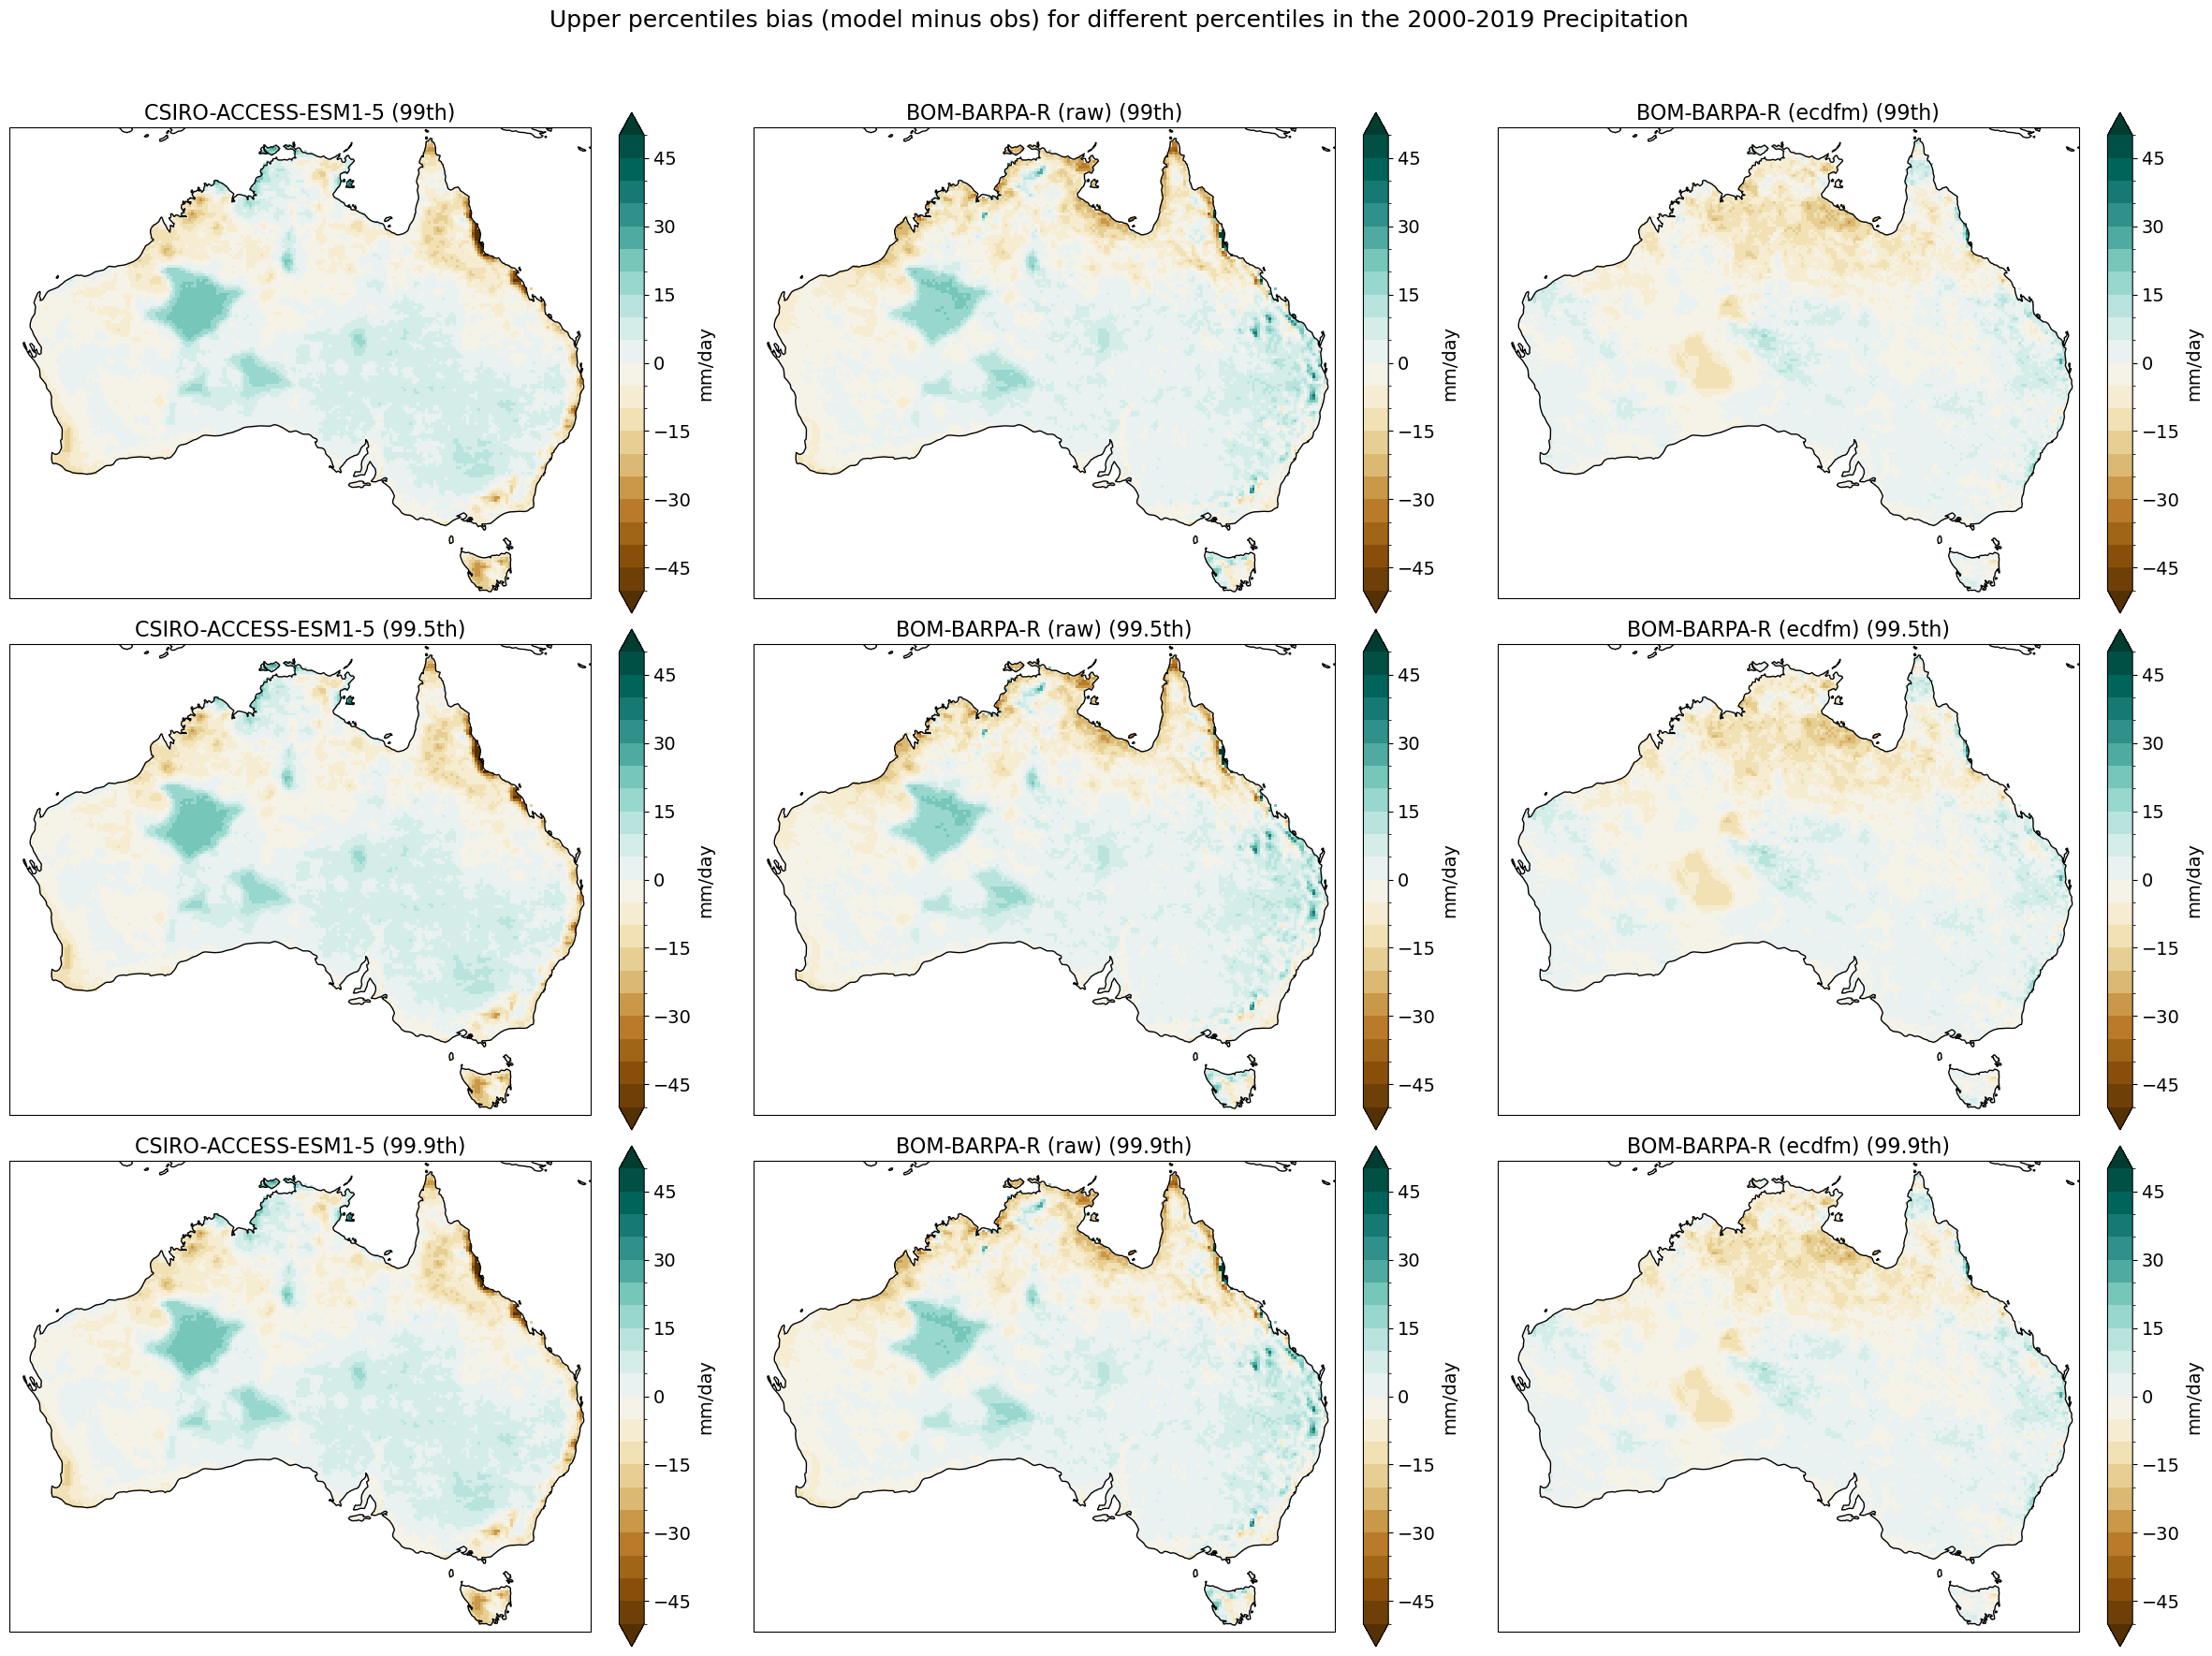

In [37]:
plot_comparison('pr', 'BOM-BARPA-R', 'BrBG', np.arange(-50, 50.1, 5))

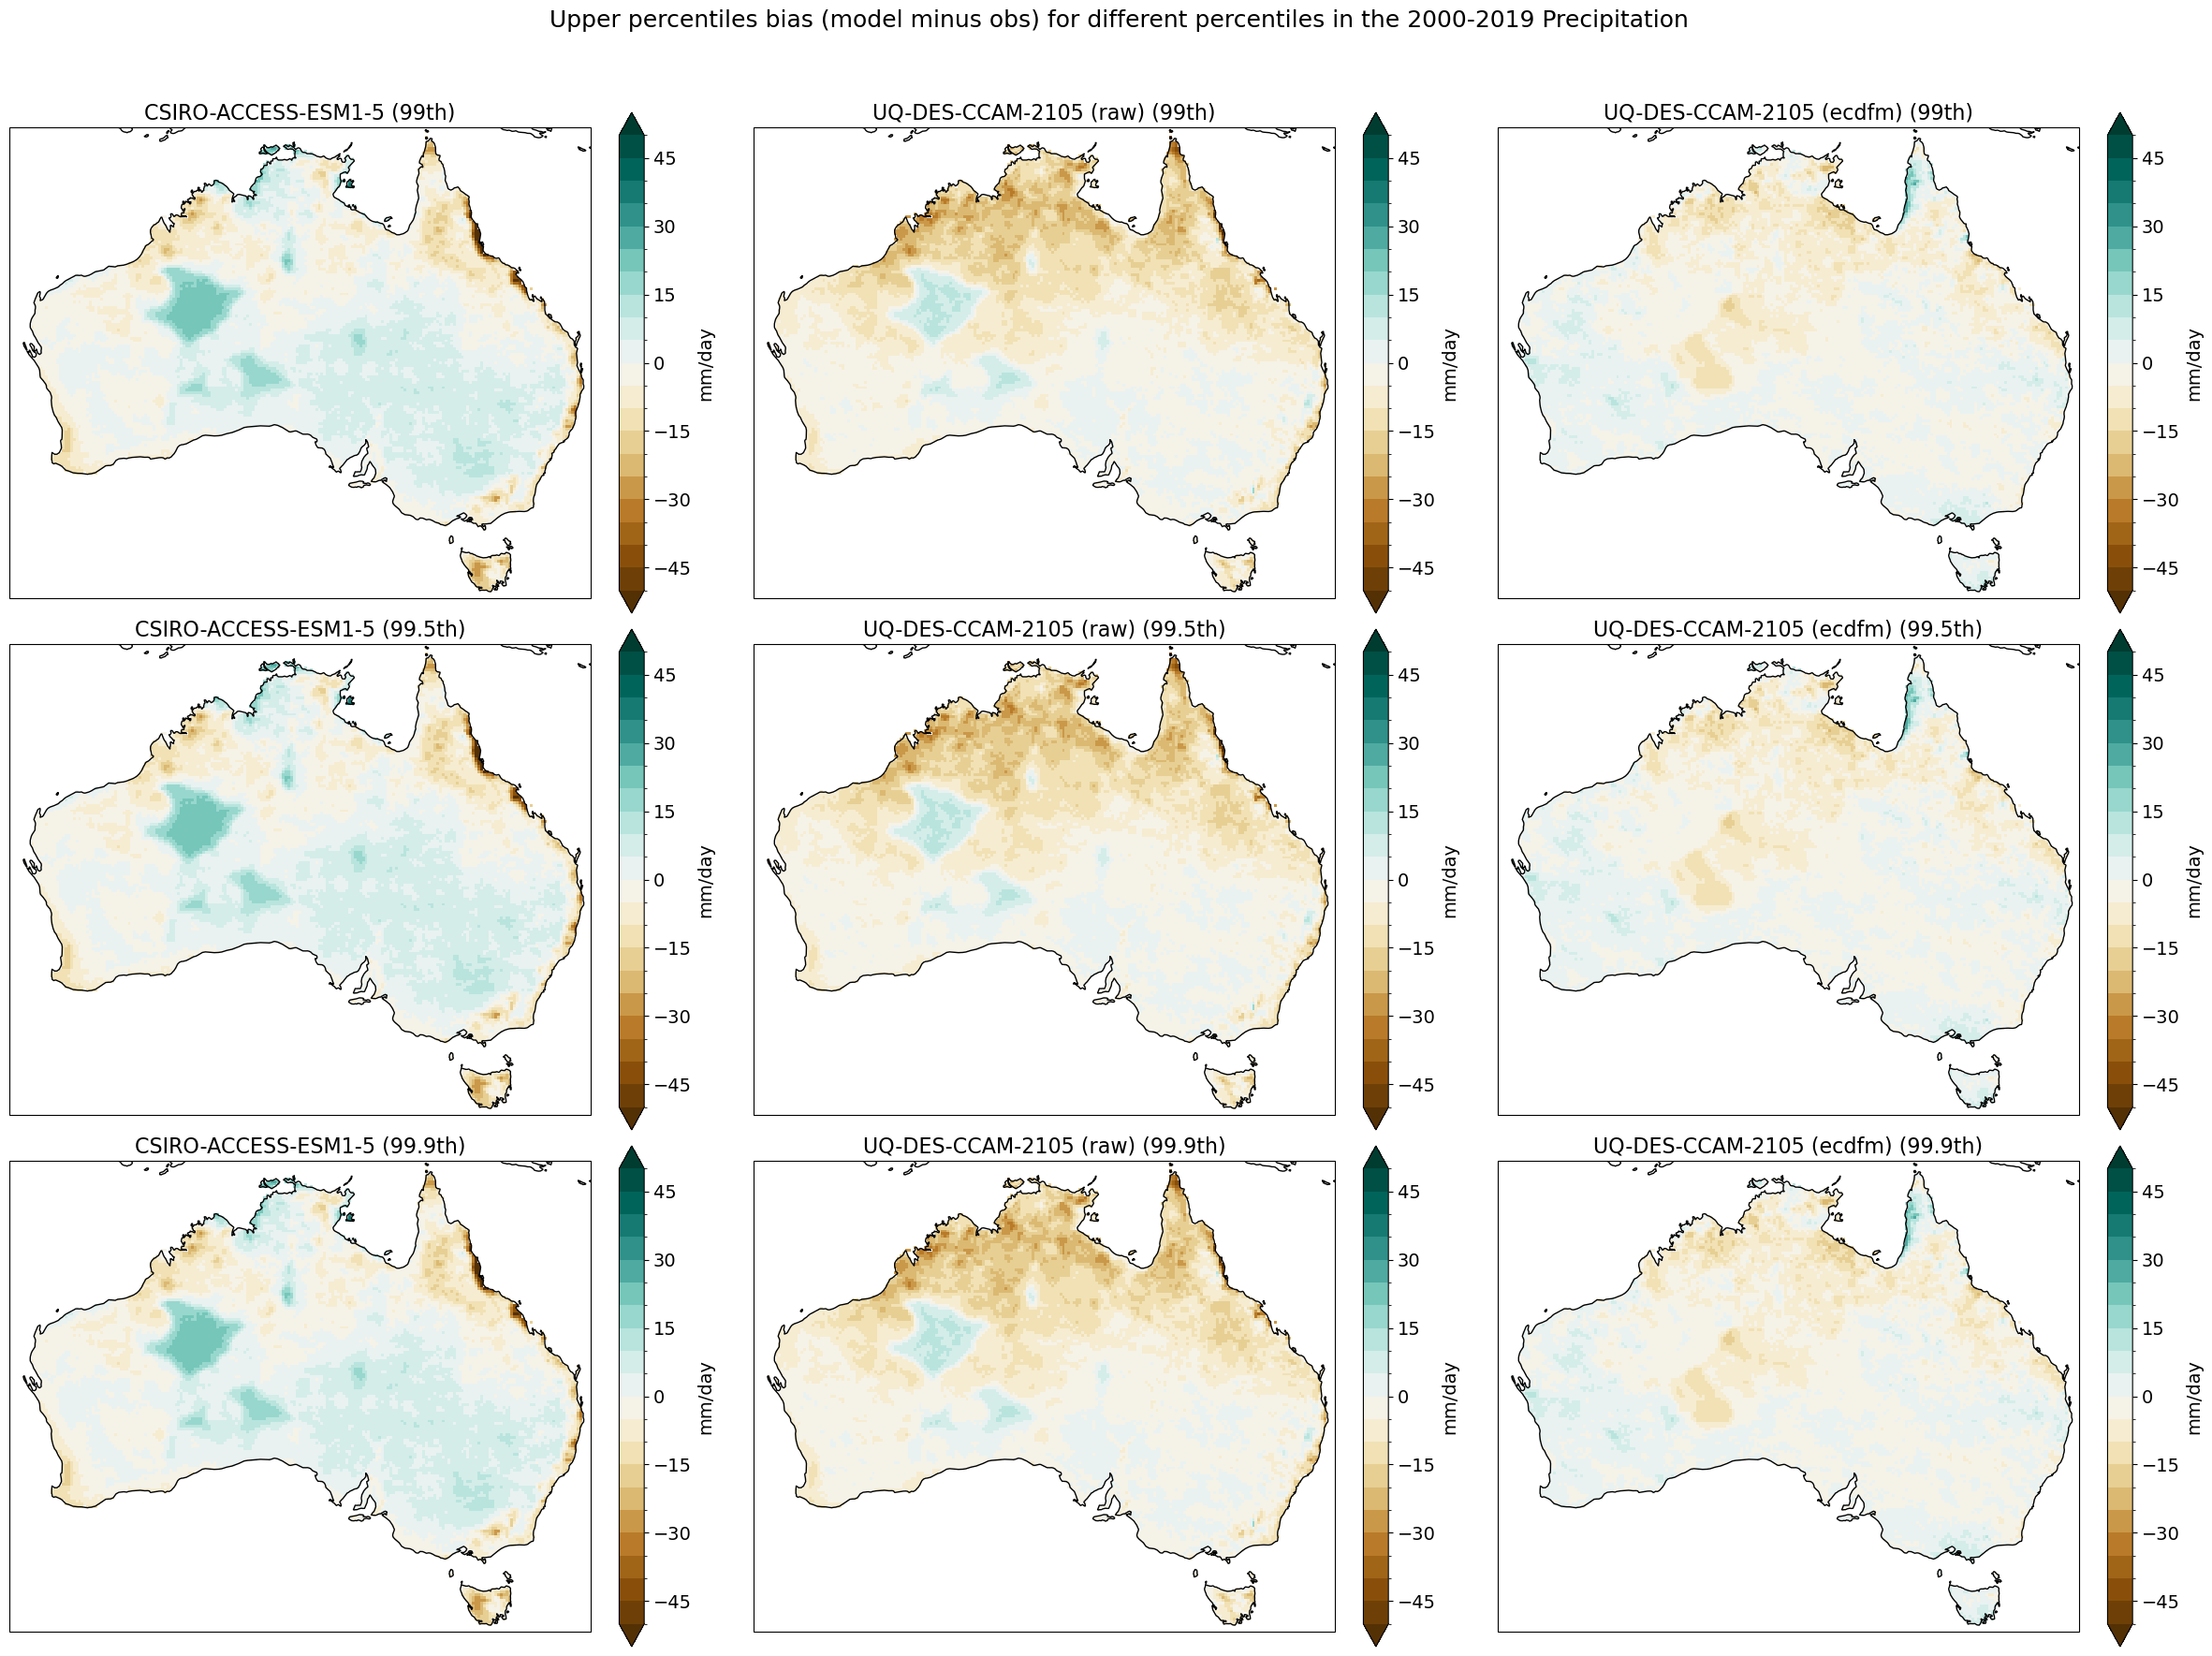

In [38]:
plot_comparison('pr', 'UQ-DES-CCAM-2105', 'BrBG', np.arange(-50, 50.1, 5))